In [2]:
from timbr import Snapshot
%reload_ext timbr.notebook
%timbr SnapshotSelector

<IPython.core.display.Javascript object>

In [3]:
data = Snapshot("/Users/chelm/.timbr/data/Yolo California with Thumbnails (RapidEye).h5")

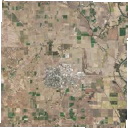

20141018_195233_1056919_RapidEye-2 2015-08-24T16:43:30.420563+00:00


In [4]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import Image, display
import base64 as b64

@interact(i=widgets.IntSlider(min=0,max=len(data)-1,step=1,value=0))
def f(i):
    display(Image(data=b64.b64decode(data[i][-1]["thumbnail"]["__data__"]), width=250, height=250))
    print data[i][-1]["id"], data[i][-1]["properties"]["published"]

In [48]:
from planet import api
import sys, os
import urllib2, httplib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class NoRedirection(urllib2.HTTPErrorProcessor):
    def http_response(self, request, response):
        return response
    https_response = http_response

opener = urllib2.build_opener(NoRedirection)

def get_image(scene, scene_type='visual', data_dir="./planet_images"):
    img_dir = os.path.join(data_dir, scene_type)
    if not os.path.exists( img_dir ):
        os.makedirs(img_dir)
        
    url = scene['properties']['data']['products'][scene_type]['full']
    
    filename = os.path.join(img_dir, '%s_%s.tif' % (scene['id'], scene_type)) 
    req = urllib2.Request(url, headers={"Authorization": "api-key %s" % api_key})
    response = opener.open(req)
    
    if 'Location' in response.headers:
        redirect_url = response.headers['Location']
        req = urllib2.Request(redirect_url)
        response = opener.open(req)
    
    CHUNK = 16 * 1024
    total = 0
    with open(filename, 'wb') as f:
        while True:
            chunk = response.read(CHUNK)
            if not chunk:
                sys.stdout.flush()
                break
                
            total += CHUNK
            sys.stdout.flush()
            sys.stdout.write('\r>> Downloading %s %d' % (filename, total))
            f.write(chunk)
            
            

api_key    = "65a347d4358348189a800a5eac3bcde7"
data_dir   = './yolo_ndvi/'
scene_type = 'analytic'                    

scene_ids  = [
    "20160501_194712_1056919_RapidEye-1",
    "20160403_194153_1056919_RapidEye-2", 
    "20140905_195020_1056919_RapidEye-2"
]

scenes     = {s['id']: s for i, s in data }
scene_meta = [ scenes[i] for i in scene_ids ]
    
for scene in scene_meta:
    filename = os.path.join(data_dir, scene_type, scene['id'] + '_' + scene_type + '.tif')
    if not os.path.exists(filename):
        get_image(scene, scene_type=scene_type, data_dir=data_dir)
        
    sys.stdout.write('Found %s \n' % (filename,))
     

Found ./yolo_ndvi/analytic/20160501_194712_1056919_RapidEye-1_analytic.tif 
Found ./yolo_ndvi/analytic/20160403_194153_1056919_RapidEye-2_analytic.tif 
Found ./yolo_ndvi/analytic/20140905_195020_1056919_RapidEye-2_analytic.tif 


In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import rasterio

def create_index(image_path, index_type, cmap="Greens", show=True):
    def _calculate(NIR, Red, Green, Blue):
        if index_type == 'NDVI':
            return (NIR - Red)/(NIR + Red)
        elif index_type == 'NDWI':
            return (Green - NIR)/(Green + NIR)
        else:
            return ((NIR - Red)/(NIR + Red + 0.5)) * (1 + 0.5)
    
    with rasterio.drivers():
        with rasterio.open(image_path) as src:
            b, g, r, z, nir, a = src.read().astype(np.float32)
            index = _calculate(nir, r, g, b)            
            index = (index + 1) * (2**15 - 1)
            index = index.astype(np.uint16)
            
            if show:
                fig, ax = plt.subplots(1, figsize=(7,7), facecolor='white')
                ax.axis('off')
                img = ax.imshow(index, cmap=cmap)
                
            return index


In [50]:
imgs = ['./yolo_ndvi/analytic/20140905_195020_1056919_RapidEye-2_analytic.tif',
        './yolo_ndvi/analytic/20160403_194153_1056919_RapidEye-2_analytic.tif',
        './yolo_ndvi/analytic/20160501_194712_1056919_RapidEye-1_analytic.tif']   

ndvis = [create_index(i, 'NDVI', show=False) for i in imgs]

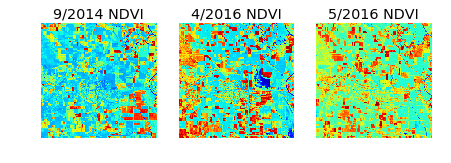

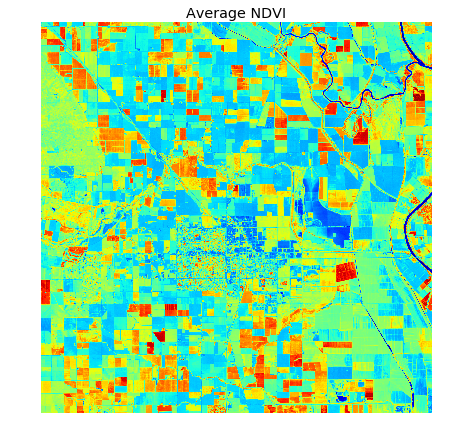

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7,5), facecolor='white')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.set_title('9/2014 NDVI')
ax1.imshow(ndvis[0])
ax2.set_title('4/2016 NDVI')
ax2.imshow(ndvis[1])
ax3.set_title('5/2016 NDVI')
ax3.imshow(ndvis[2])

fig, ax = plt.subplots(1, figsize=(7,7), facecolor='white')
ax.axis('off')
avg = np.mean(np.dstack([ndvis[0], ndvis[1], ndvis[2]]), axis=2)
img = ax.imshow(avg)
ax.set_title('Average NDVI')
plt.show()

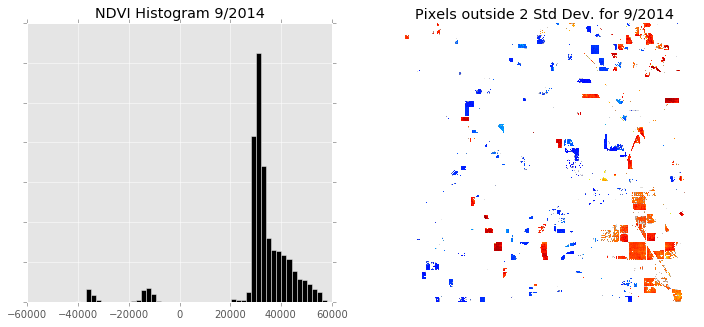

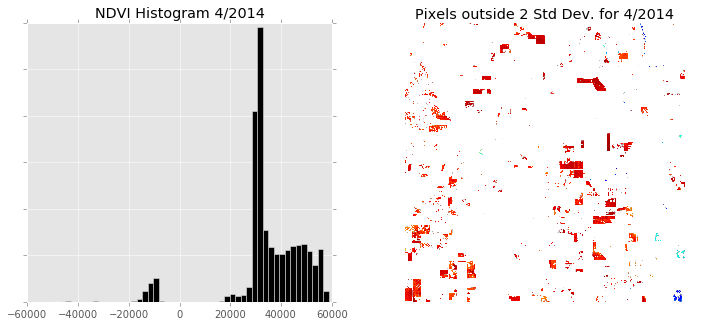

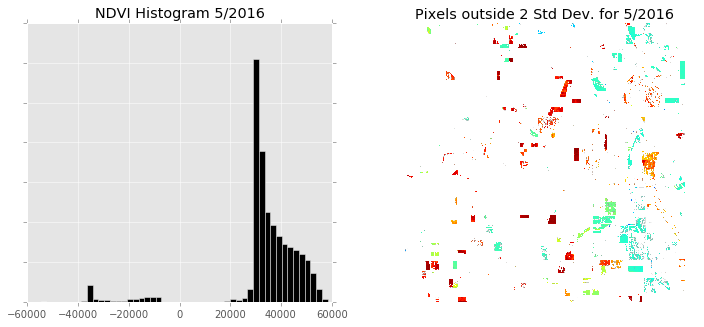

In [75]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
%matplotlib inline

def compare(img, avg, year):
    maxval = 65535.0
    diff = np.abs(avg - img) / maxval
    
    anomaly = np.zeros(diff.shape)
    std = np.std(diff)
    mean = np.mean(diff)
    
    low = diff > (mean - (std*2))
    anomaly[~low] = 1

    high = diff < (mean + (std*2))
    anomaly[~high] = 1
    
    masked = np.ma.array(data=img, mask=~anomaly.astype(bool))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), facecolor='white')
    #ax1.set_xlim((0,1))
    ax1.set_title('NDVI Histogram ' + year)
    ax1.hist((masked.flatten() - maxval), bins=50, color="k")
    ax1.yaxis.set_major_formatter(plt.NullFormatter())
    ax2.axis('off')
    ax2.set_title('Pixels outside 2 Std Dev. for ' + year)
    ax2.imshow(masked - maxval)
    plt.show()
    return anomaly
    
titles = ['9/2014', '4/2014', '5/2016']
anoms = [compare(n, avg, titles[i]) for i, n in enumerate(ndvis)]


In [88]:
# using an ndvi array
# create a masked array of anomalous pixels
# collect zonal stats from yolo landuse - attach to vectors - discard where none
# map vectors by landuse and mean ndvi over time
import os
import rasterio
import json

import rasterio.features
from affine import Affine
from shapely.geometry import shape
import numpy as np

import matplotlib as mpl
import matplotlib.cm
import matplotlib.colors
import numpy as np

def get_geom_bounds(geojson, tif):
    with open(geojson) as f:
        data = json.load(f)
        with rasterio.open( tif, 'r') as raster:
         
            for i, feature in enumerate(data['features']):
                geometry = shape(feature['geometry'])
                ul = raster.index(*geometry.bounds[0:2])
                lr = raster.index(*geometry.bounds[2:4])
                feature['properties']['ul'] = ul
                feature['properties']['lr'] = lr
                feature['properties']['affine'] = raster.affine
                #shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)
    
    return data['features']

geojson = './yolo_landuse.json'
if not os.path.exists(geojson):
    import urllib
    urllib.urlretrieve('https://raw.githubusercontent.com/chelm/geodata/master/yolo_landuse.json', geojson)
    
features = get_geom_bounds(geojson, 'yolo_ndvi/analytic/wgs84/20160403_194153_1056919_RapidEye-2_analytic.wgs84.tif')
print features[0]['properties']['affine']


| 0.00, 0.00,-121.90|
| 0.00,-0.00, 38.81|
| 0.00, 0.00, 1.00|


In [164]:
def intersect(features, anomaly):
    matched = []
    for f in features:
        geometry = shape(f['geometry'])
        ul = f['properties']['ul']
        lr = f['properties']['lr']
        
        #print ul, lr
        t = f['properties']['affine']
        shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)
        window = anomaly[lr[0]: ul[0]+1, ul[1]:lr[1]+1]
        try: 
            mask = rasterio.features.rasterize(
                [(geometry, 0)],
                out_shape = window.shape,
                transform = shifted_affine,
                fill = 1,
                all_touched = True,
                dtype = np.uint8)
            
            masked_data = np.ma.array(data=window, mask=mask.astype(bool))
            summed = np.sum(masked_data)
            if summed > 0.0 and str(f['properties']['WATERSOURC']).strip() != '*':
                f['properties']['ndvi'] = np.mean(masked_data)
                matched.append(f)
        except:
            pass
    return matched
    
ndvi_features = intersect(features, anoms[0])

539


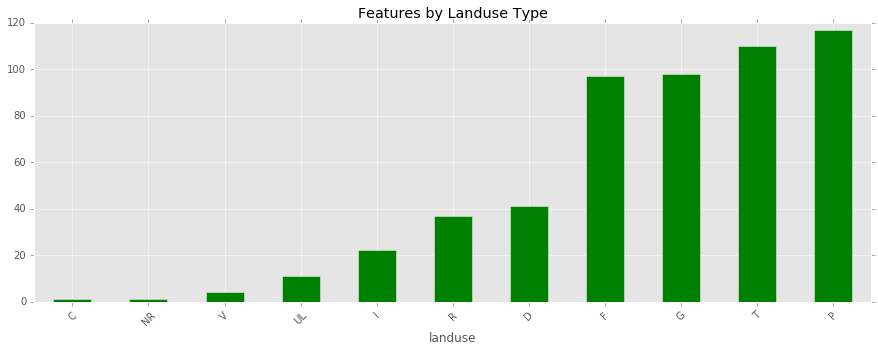

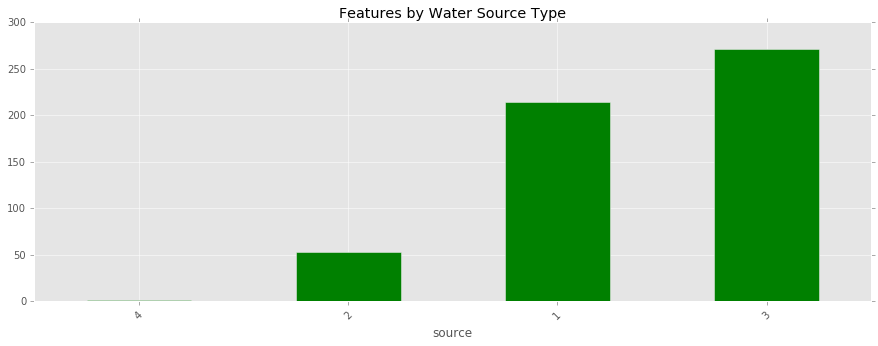

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
%matplotlib inline

stats = pd.DataFrame.from_records([
        (f['properties']['CLASS1'], f['properties']['WATERSOURC'], f['properties']['ndvi']) 
        for f in ndvi_features], columns=['landuse', 'source', 'ndvi'])

landuse = stats.groupby('landuse')
landuse.size().sort_values().plot(kind='bar', color="green", figsize=(15, 5), rot=45, title='Features by Landuse Type')
plt.show()

irr = stats.groupby('source')
irr.size().sort_values().plot(kind='bar', color="green", figsize=(15, 5), rot=45, title='Features by Water Source Type')
plt.show()

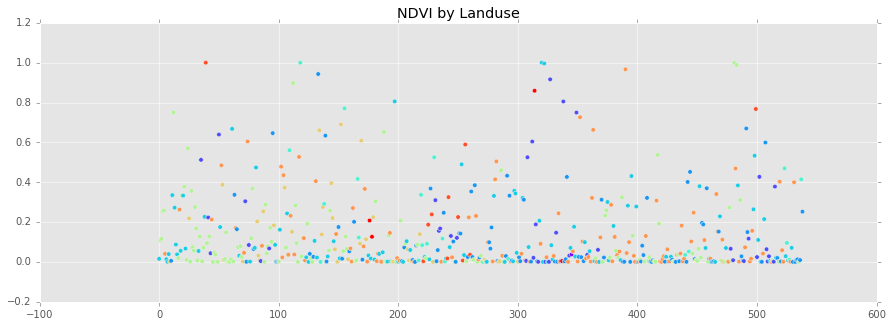

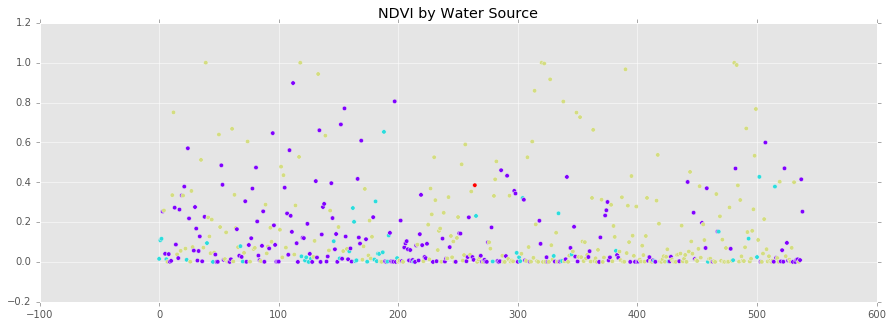

In [182]:

def n_colors(n, colormap=mpl.cm.rainbow):
    data = np.linspace(0.0,1.0,n)
    c = [mpl.colors.rgb2hex(d[0:3]) for d in colormap(data)]
    return c

keys = landuse['landuse'].size().index
use_colors = dict(zip(keys, n_colors(len(keys))))

keys = irr['source'].size().index
source_colors = dict(zip(keys, n_colors(len(keys))))

def plot( df, title=None ):
    f, ax1 = plt.subplots(1, figsize=(15,5))
    ax1.set_title('NDVI by Landuse')
    ax1.scatter(list(df.index), [df['ndvi'][i] for i in df.index], c=[use_colors[df['landuse'][i]] for i in df.index])
    plt.show()
    
    f, ax1 = plt.subplots(1, figsize=(15,5))
    ax1.set_title('NDVI by Water Source')
    ax1.scatter(list(df.index), [df['ndvi'][i] for i in df.index], c=[source_colors[df['source'][i]] for i in df.index])
    plt.show()

plot( stats, title="NDVI By Landuse")


